# Loading Modules

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from utils import view_dataset
from stn import STN_128x128 # importing the network

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [21]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}


# Exploring the MNIST with where noise parameters

- 128x128 pixel with shift, noise and circular mask

In [22]:
args.offset_max = 40 #like in the paper

In [23]:
args.offset_std = 40
args.contrast = 0.3
transform_big = transforms.Compose([
    RetinaFill(N_pic=args.N_pic),
    WhereShift(args, radius = 40),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf, flexible=True),
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor()
    #FullfieldRetinaWhiten(N_pic=args.N_pic),
    #FullfieldRetinaTransform(Retina(args).retina_transform_vector),
    #FullfieldToFloatTensor(),
    # Normalize(fullfield=True)
    # transforms.Normalize((args.mean,), (args.std,))
])

train_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [24]:
data_big, label_big = next(iter(train_loader))

- Let's view a couple of examples

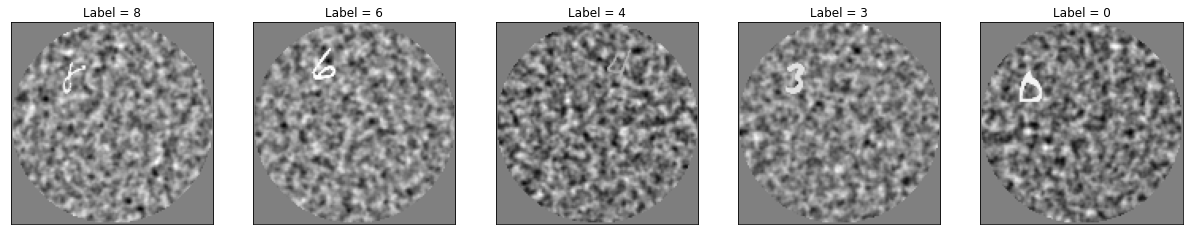

In [25]:
data = view_dataset(train_loader, n=5)

In [26]:
#data.savefig("../figures/data_128x128_noisy_no_shift_.png")

- To replace the first convolutional layer of the spatial transformer network.

# Loading the model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
PATH = "../models/stn_128x128_shift_0.7.pt"
model = torch.load(PATH).to(device)
#model = STN_128x128().to(device)

In [29]:
def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            output = model(data)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * correct / len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

# Training parameters of the What/Where model

In [30]:
eccentricities = np.linspace(args.offset_max, 0, 9, endpoint=False)[::-1]
eccentricities

array([ 4.44444444,  8.88888889, 13.33333333, 17.77777778, 22.22222222,
       26.66666667, 31.11111111, 35.55555556, 40.        ])

In [31]:
contrasts = (0.7, 0.5, 0.3)

# Training on contrast 0.7

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [81]:
for offset in eccentricities:

    args.offset_std = offset

    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf,
                        flexible=True), 
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor()
    ])
    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform_big,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform_big,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    print("Training on eccentricity=%s" % (offset))
    args.epochs = 10

    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        test(test_loader)
        scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Training on eccentricity=4.444444444444443
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 2.304852
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 2.292329
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 2.298438
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 2.296064
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 2.299860
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 2.298772

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 2.292976
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 2.297777
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 2.297818
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 2.297024
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 2.292520
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 2.293354

Test set: Average loss: 0.0229, Accuracy: 1135/10000 (11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 2.281189
Train Epoch

Train Epoch: 10/10 [0/60000 (0%)]	Loss: 0.083132
Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.131813
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.108234
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.255727
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.179590
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.065171

Test set: Average loss: 0.0013, Accuracy: 9615/10000 (96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Training on eccentricity=13.333333333333332
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.249447
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.177673
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.227874
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.127863
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.315938
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.288945

Test set: Average loss: 0.0033, Accuracy: 8968/10000 (90%)

Adjusting learning rate of group 0 to 1.0000e-02.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.350420
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.120145
T

Training on eccentricity=17.77777777777778
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.145230
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.097280
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.089744
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.124231
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.128400
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.073097

Test set: Average loss: 0.0010, Accuracy: 9687/10000 (97%)

Adjusting learning rate of group 0 to 1.0000e-03.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.129342
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.125507
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.112093
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 0.184709
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 0.095817
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.084763

Test set: Average loss: 0.0009, Accuracy: 9729/10000 (97%)

Adjusting learning rate of group 0 to 1.0000e-03.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.083158
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 0.076468
Train Ep

Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.114564
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.058616
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.063734
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.026515
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.020092

Test set: Average loss: 0.0008, Accuracy: 9737/10000 (97%)

Adjusting learning rate of group 0 to 1.0000e-03.
Training on eccentricity=26.666666666666664
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.053372
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.064206
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.047744
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.106731
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.023458
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.056775

Test set: Average loss: 0.0008, Accuracy: 9743/10000 (97%)

Adjusting learning rate of group 0 to 1.0000e-03.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.032953
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.055818
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.0843

Training on eccentricity=31.11111111111111
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.018197
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.112215
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.081552
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.153576
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.048008
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.020594

Test set: Average loss: 0.0007, Accuracy: 9771/10000 (98%)

Adjusting learning rate of group 0 to 1.0000e-04.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.067785
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.122150
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.025904
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 0.096689
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 0.087506
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.022904

Test set: Average loss: 0.0007, Accuracy: 9780/10000 (98%)

Adjusting learning rate of group 0 to 1.0000e-04.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.031517
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 0.084901
Train Ep

Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.076867
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.063937
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.098811
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.070052
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.027403

Test set: Average loss: 0.0007, Accuracy: 9790/10000 (98%)

Adjusting learning rate of group 0 to 1.0000e-04.
Training on eccentricity=40.0
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.077238
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.116854
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.064455
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.109543
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.045956
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.094192

Test set: Average loss: 0.0007, Accuracy: 9776/10000 (98%)

Adjusting learning rate of group 0 to 1.0000e-04.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.061236
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.069133
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.078466
Train Epoch

# Training on lesser contrasts

In [32]:
optimizer = optim.SGD(model.parameters(), lr=0.00001) # divide another time by 10
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-05.


In [33]:
accuracies = []
for contrast in (0.5, 0.3):
    
    print("training on contrast %s" %(contrast))

    args.offset_std = 40 #train while the maximum range is 40
    args.contrast = contrast
    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf, flexible=True),
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor()
    ])

    train_loader = torch.utils.data.DataLoader(MNIST('../data',
                            train=True,
                            download=True,
                            transform=transform_big,
                            ),
                            batch_size=args.minibatch_size,
                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST('../data',
                            train=False,
                            download=True,
                            transform=transform_big,
                            ),
                            batch_size=args.minibatch_size,
                            shuffle=True)

    args.epochs = 30
    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        acc = test(test_loader)
        accuracies.append(acc)
        scheduler.step()

training on contrast 0.5
Train Epoch: 1/30 [0/60000 (0%)]	Loss: 0.162386
Train Epoch: 1/30 [10000/60000 (17%)]	Loss: 0.195461
Train Epoch: 1/30 [20000/60000 (33%)]	Loss: 0.282876
Train Epoch: 1/30 [30000/60000 (50%)]	Loss: 0.190954
Train Epoch: 1/30 [40000/60000 (67%)]	Loss: 0.359763
Train Epoch: 1/30 [50000/60000 (83%)]	Loss: 0.200099

Test set: Average loss: 0.0018, Accuracy: 9442/10000 (94%)

Adjusting learning rate of group 0 to 1.0000e-05.
Train Epoch: 2/30 [0/60000 (0%)]	Loss: 0.117604
Train Epoch: 2/30 [10000/60000 (17%)]	Loss: 0.241985
Train Epoch: 2/30 [20000/60000 (33%)]	Loss: 0.206573
Train Epoch: 2/30 [30000/60000 (50%)]	Loss: 0.128849
Train Epoch: 2/30 [40000/60000 (67%)]	Loss: 0.133660
Train Epoch: 2/30 [50000/60000 (83%)]	Loss: 0.144370

Test set: Average loss: 0.0017, Accuracy: 9488/10000 (95%)

Adjusting learning rate of group 0 to 1.0000e-05.
Train Epoch: 3/30 [0/60000 (0%)]	Loss: 0.175152
Train Epoch: 3/30 [10000/60000 (17%)]	Loss: 0.222370
Train Epoch: 3/30 [20000/6

Train Epoch: 20/30 [20000/60000 (33%)]	Loss: 0.093224
Train Epoch: 20/30 [30000/60000 (50%)]	Loss: 0.136983
Train Epoch: 20/30 [40000/60000 (67%)]	Loss: 0.151908
Train Epoch: 20/30 [50000/60000 (83%)]	Loss: 0.071139

Test set: Average loss: 0.0014, Accuracy: 9560/10000 (96%)

Adjusting learning rate of group 0 to 1.0000e-05.
Train Epoch: 21/30 [0/60000 (0%)]	Loss: 0.255697
Train Epoch: 21/30 [10000/60000 (17%)]	Loss: 0.139953
Train Epoch: 21/30 [20000/60000 (33%)]	Loss: 0.138427
Train Epoch: 21/30 [30000/60000 (50%)]	Loss: 0.236598
Train Epoch: 21/30 [40000/60000 (67%)]	Loss: 0.242665
Train Epoch: 21/30 [50000/60000 (83%)]	Loss: 0.175609

Test set: Average loss: 0.0014, Accuracy: 9561/10000 (96%)

Adjusting learning rate of group 0 to 1.0000e-05.
Train Epoch: 22/30 [0/60000 (0%)]	Loss: 0.073746
Train Epoch: 22/30 [10000/60000 (17%)]	Loss: 0.250722
Train Epoch: 22/30 [20000/60000 (33%)]	Loss: 0.061520
Train Epoch: 22/30 [30000/60000 (50%)]	Loss: 0.127105
Train Epoch: 22/30 [40000/60000 

Train Epoch: 9/30 [30000/60000 (50%)]	Loss: 0.495608
Train Epoch: 9/30 [40000/60000 (67%)]	Loss: 0.804326
Train Epoch: 9/30 [50000/60000 (83%)]	Loss: 0.506452

Test set: Average loss: 0.0065, Accuracy: 8072/10000 (81%)

Adjusting learning rate of group 0 to 1.0000e-06.
Train Epoch: 10/30 [0/60000 (0%)]	Loss: 0.729764
Train Epoch: 10/30 [10000/60000 (17%)]	Loss: 0.768108
Train Epoch: 10/30 [20000/60000 (33%)]	Loss: 0.517352
Train Epoch: 10/30 [30000/60000 (50%)]	Loss: 0.780721
Train Epoch: 10/30 [40000/60000 (67%)]	Loss: 0.479504
Train Epoch: 10/30 [50000/60000 (83%)]	Loss: 0.663728

Test set: Average loss: 0.0064, Accuracy: 8088/10000 (81%)

Adjusting learning rate of group 0 to 1.0000e-06.
Train Epoch: 11/30 [0/60000 (0%)]	Loss: 0.476791
Train Epoch: 11/30 [10000/60000 (17%)]	Loss: 0.709348
Train Epoch: 11/30 [20000/60000 (33%)]	Loss: 0.550470
Train Epoch: 11/30 [30000/60000 (50%)]	Loss: 0.620349
Train Epoch: 11/30 [40000/60000 (67%)]	Loss: 0.690284
Train Epoch: 11/30 [50000/60000 (83

Train Epoch: 28/30 [40000/60000 (67%)]	Loss: 0.565546
Train Epoch: 28/30 [50000/60000 (83%)]	Loss: 0.423111

Test set: Average loss: 0.0058, Accuracy: 8222/10000 (82%)

Adjusting learning rate of group 0 to 1.0000e-06.
Train Epoch: 29/30 [0/60000 (0%)]	Loss: 0.576326
Train Epoch: 29/30 [10000/60000 (17%)]	Loss: 0.563078
Train Epoch: 29/30 [20000/60000 (33%)]	Loss: 0.559443
Train Epoch: 29/30 [30000/60000 (50%)]	Loss: 0.515696
Train Epoch: 29/30 [40000/60000 (67%)]	Loss: 0.596448
Train Epoch: 29/30 [50000/60000 (83%)]	Loss: 0.622063

Test set: Average loss: 0.0058, Accuracy: 8218/10000 (82%)

Adjusting learning rate of group 0 to 1.0000e-06.
Train Epoch: 30/30 [0/60000 (0%)]	Loss: 0.427896
Train Epoch: 30/30 [10000/60000 (17%)]	Loss: 0.806153
Train Epoch: 30/30 [20000/60000 (33%)]	Loss: 0.565971
Train Epoch: 30/30 [30000/60000 (50%)]	Loss: 0.454100
Train Epoch: 30/30 [40000/60000 (67%)]	Loss: 0.473101
Train Epoch: 30/30 [50000/60000 (83%)]	Loss: 0.423911

Test set: Average loss: 0.0058,

# Training accuracy

In [42]:
accuracy = [
    0.1135, 0.1135, 0.1317, 0.2374, 0.4015, 0.4956, 0.5147, 0.5731, 0.4378,
    0.8005, 0.8586, 0.8557, 0.9205, 0.9323, 0.9367, 0.946, 0.9479, 0.9464,
    0.9613, 0.9615, 0.8968, 0.9325, 0.9493, 0.9595, 0.9645, 0.9645, 0.9577,
    0.9671, 0.9321, 0.97, 0.9687, 0.9729, 0.9725, 0.9741, 0.9746, 0.9753,
    0.9749, 0.9756, 0.975, 0.9762, 0.9722, 0.9734, 0.9746, 0.9744, 0.9748,
    0.9757, 0.9759, 0.9756, 0.9751, 0.9737, 0.9743, 0.976, 0.9755, 0.9749,
    0.9768, 0.9772, 0.9772, 0.9768, 0.9784, 0.9776, 0.9771, 0.978, 0.9777,
    0.9772, 0.9776, 0.9777, 0.9776, 0.9772, 0.9777, 0.9775, 0.9775, 0.977,
    0.9778, 0.9774, 0.9786, 0.9778, 0.9788, 0.9779, 0.9784, 0.979, 0.9776,
    0.9775, 0.9776, 0.9771, 0.9773, 0.9779, 0.9763, 0.9769, 0.9774, 0.9775,
    0.9442, 0.9488, 0.9515, 0.9528, 0.9533, 0.9536, 0.9532, 0.9536, 0.9545,
    0.9544, 0.9547, 0.9549, 0.9549, 0.9558, 0.9562, 0.9559, 0.9564, 0.9561,
    0.9563, 0.956, 0.9561, 0.9562, 0.9558, 0.9563, 0.9564, 0.9567, 0.9569,
    0.9571, 0.9575, 0.9575, 0.7906, 0.7939, 0.7966, 0.7996, 0.8013, 0.8024,
    0.8039, 0.8054, 0.8072, 0.8088, 0.811, 0.8118, 0.8118, 0.813, 0.8138,
    0.8139, 0.8144, 0.8159, 0.8167, 0.8172, 0.8178, 0.8185, 0.82, 0.8201,
    0.8201, 0.8209, 0.8213, 0.8222, 0.8218, 0.8221
]

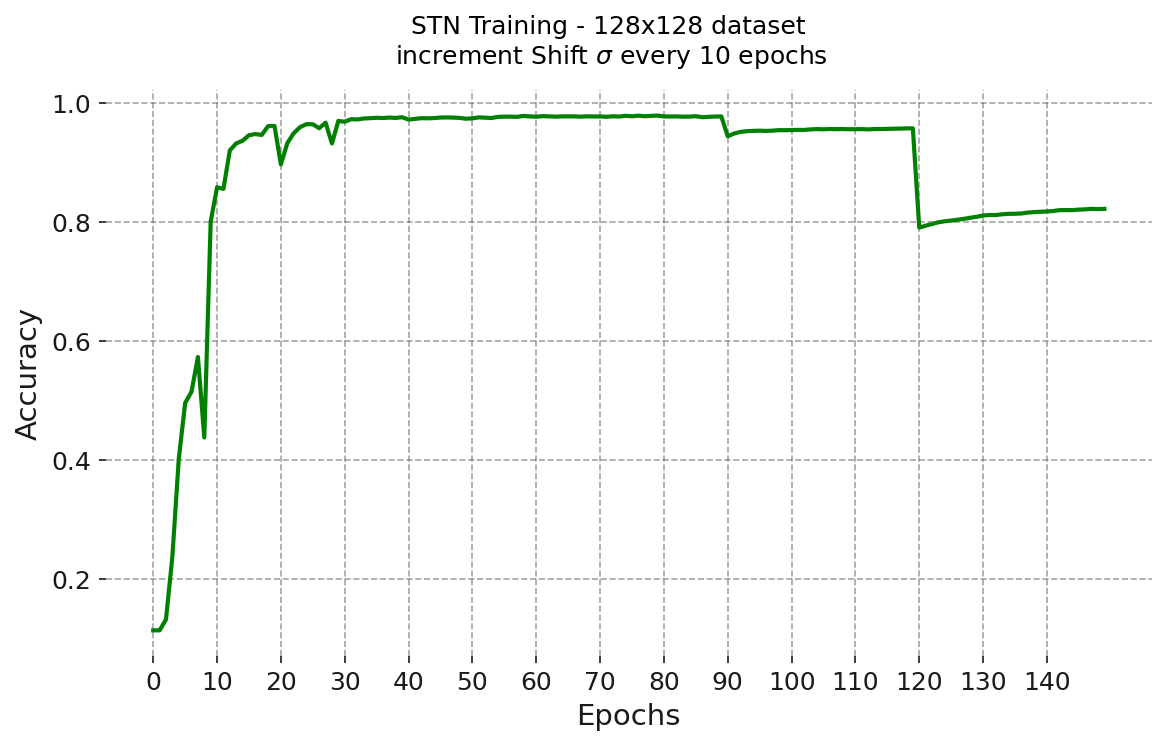

In [54]:
plt.style.use("gadfly")
fig, ax = plt.subplots(1, 1, dpi=150, figsize = (9,5))
ax.plot(accuracy, 'g')

ax.set_xticks([e for e in range(0, 150, 10)])  
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")

#ax.grid(axis='x', linestyle='--')
fig.suptitle("STN Training - 128x128 dataset \nincrement Shift $\sigma$ every 10 epochs")
#fig.savefig('../figures/acc_training_stn_128x128.png')

# Saving the model trained on all eccentricities and contrasts

In [55]:
final = "../models/stn_128x128.pt"
torch.save(model, final)

# Visualizing some results of transformation

In [36]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp
thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:16, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        data = data.type(torch.cuda.FloatTensor)
        
        output_tensor, theta = model.stn(data)
        thetas.append(theta)

        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor, nrow=4))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor, nrow=4))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        #f.savefig('../figures/contrast_128x128.png')

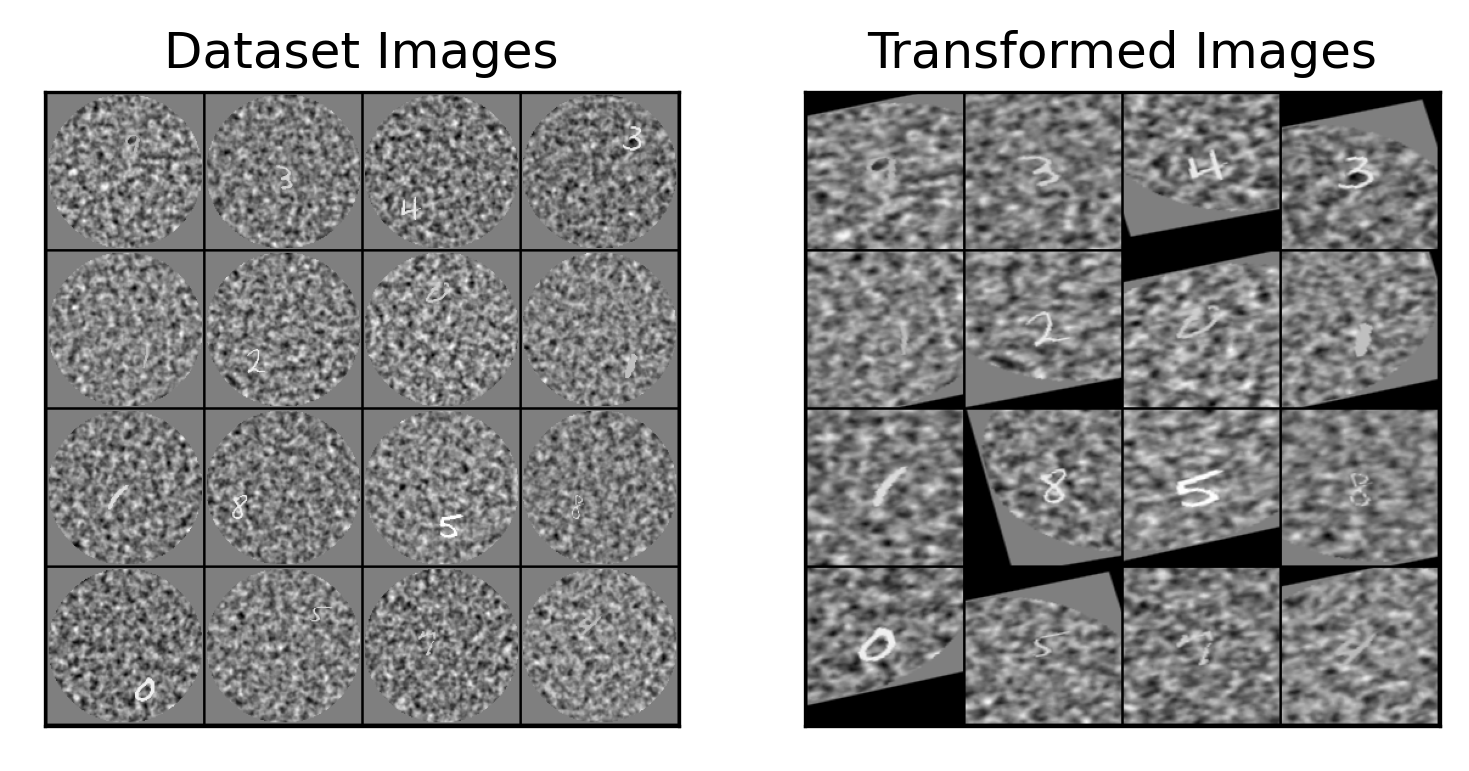

In [37]:
visualize_stn()

In [14]:
thetas

[tensor([[[ 0.4951, -0.1485, -0.0360],
          [ 0.1504,  0.7387,  0.5894]],
 
         [[ 0.5198, -0.1395, -0.1011],
          [ 0.1520,  0.7576, -0.3377]],
 
         [[ 0.5347, -0.1421, -0.2068],
          [ 0.1451,  0.7559,  0.0730]],
 
         [[ 0.5144, -0.1571,  0.4628],
          [ 0.1547,  0.7554, -0.3223]],
 
         [[ 0.5367, -0.1524,  0.2181],
          [ 0.1541,  0.7656, -0.0430]],
 
         [[ 0.5353, -0.1448, -0.1069],
          [ 0.1472,  0.7590,  0.0645]],
 
         [[ 0.5149, -0.1585,  0.4712],
          [ 0.1564,  0.7537,  0.0376]],
 
         [[ 0.5067, -0.1553,  0.3986],
          [ 0.1552,  0.7492,  0.2409]],
 
         [[ 0.5385, -0.1434, -0.0816],
          [ 0.1504,  0.7623, -0.0798]],
 
         [[ 0.5416, -0.1449, -0.0526],
          [ 0.1495,  0.7644,  0.0152]],
 
         [[ 0.5167, -0.1627,  0.5351],
          [ 0.1526,  0.7557, -0.3290]],
 
         [[ 0.5220, -0.1369, -0.2197],
          [ 0.1503,  0.7540, -0.3562]],
 
         [[ 0.5244, -0.1489,

# Performance of our STN

- Calculating accuracy in function of eccentricity and contrast for our Spatial transformer network.

In [47]:
stn_stats = {}

for contrast in contrasts:
    print("Testing on contrast = %s"%(contrast))
    
    accuracies = []
    
    for ecc in eccentricities: 

        transform_big = transforms.Compose([
            RetinaFill(N_pic=args.N_pic),
            WhereShift(args, radius = ecc), # given eccentricity
            RetinaBackground(contrast=contrast, # given contrast
                             noise=args.noise,
                             sf_0=args.sf_0,
                             B_sf=args.B_sf, flexible=False), # a fixed contrast
            RetinaMask(N_pic=args.N_pic),
            transforms.ToTensor()
        ])
        train_loader = torch.utils.data.DataLoader(MNIST('../data',
                                train=True,
                                download=True,
                                transform=transform_big,
                                ),
                                batch_size=args.minibatch_size,
                                shuffle=True)

        test_loader = torch.utils.data.DataLoader(MNIST('../data',
                                train=False,
                                download=True,
                                transform=transform_big,
                                ),
                                batch_size=args.minibatch_size,
                                shuffle=True)
        print("Testing on eccentricity = %s"%(ecc))
        acc = test(test_loader)
        accuracies.append(acc)

    stn_stats[contrast] = np.array(accuracies)

Testing on contrast = 0.7
Testing on eccentricity = 4.444444444444443

Test set: Average loss: 0.0009, Accuracy: 9716/10000 (97%)

Testing on eccentricity = 8.888888888888886

Test set: Average loss: 0.0010, Accuracy: 9684/10000 (97%)

Testing on eccentricity = 13.333333333333332

Test set: Average loss: 0.0010, Accuracy: 9687/10000 (97%)

Testing on eccentricity = 17.77777777777778

Test set: Average loss: 0.0011, Accuracy: 9667/10000 (97%)

Testing on eccentricity = 22.22222222222222

Test set: Average loss: 0.0013, Accuracy: 9592/10000 (96%)

Testing on eccentricity = 26.666666666666664

Test set: Average loss: 0.0014, Accuracy: 9575/10000 (96%)

Testing on eccentricity = 31.11111111111111

Test set: Average loss: 0.0018, Accuracy: 9426/10000 (94%)

Testing on eccentricity = 35.55555555555556

Test set: Average loss: 0.0029, Accuracy: 9095/10000 (91%)

Testing on eccentricity = 40.0

Test set: Average loss: 0.0030, Accuracy: 9049/10000 (90%)

Testing on contrast = 0.5
Testing on ecc

In [48]:
stn_stats

{0.7: array([0.9716, 0.9684, 0.9687, 0.9667, 0.9592, 0.9575, 0.9426, 0.9095,
        0.9049]),
 0.5: array([0.9567, 0.9574, 0.9554, 0.9589, 0.9535, 0.9492, 0.9456, 0.9338,
        0.8851]),
 0.3: array([0.4757, 0.4484, 0.4985, 0.5346, 0.5533, 0.4934, 0.3794, 0.2418,
        0.1308])}